# 1. Calibrate both CR pulses with active cancellation and no rotary echo

this CR calibration follows the CR1 (= CR calibration for un-echoed single pulse variante) experiments from: "Qiskit Pulse: Programming Quantum Computers through the Cloud with Pulses", repo in Resources folder

In [11]:
from copy import deepcopy
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.optimize as opt
from qiskit.providers.ibmq.job import job_monitor
from qiskit.providers.jobstatus import JobStatus
from qiskit.result import Result
from qiskit import pulse, transpile, assemble, schedule, IBMQ, quantum_info as qi
from qiskit.pulse.library import gaussian_square
from qiskit.pulse.transforms import align_measures
import pickle, pprint, qiskit, json
import scipy.optimize as opt
from qiskit import pulse, transpile, assemble, schedule, quantum_info as qi
from qiskit.pulse.library import gaussian_square
from qiskit.pulse.transforms import align_measures
from qiskit.ignis.verification import randomized_benchmarking as rb 
from qiskit.providers.ibmq.job import job_monitor
from qiskit.providers.jobstatus import JobStatus
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.result import Result
import qiskit

# utility for pulse schedule generation
from utils.cr_pulse_utils import create_cr_circuit, var_amp, var_phi

# utility for quantum process tomography
from utils.qpt_utils import create_qpt_experiment, extract_choi_matrix

# utility for randomized benchmarking
from utils.rb_utils import create_rb_experiment, cache_circuit

# utility for analysis
from utils.analysis_utils import (cr_3rd_order_perturbation, local_fidelity_optimization, 
                                  optimize_circuit, expectation_val, hamiltonian_reconstruction,
                                  plot_quantum_channel, ExperimentRunner)


from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit import QuantumCircuit, Aer, IBMQ

provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

# target backend
backend_name = 'ibmq_casablanca'

ibmqfactory.load_account:WARNING:2021-04-05 18:22:20,451: Credentials are already in use. The existing account in the session will be replaced.


## CR calibration for control 1, target 3 

In [1]:
# control qubit index
q1 = 1
control = q1

# target qubit index
q2 = 3
target = q2

# use cache data
use_cache = False

import os
data_dir = os.getcwd() + '\\CR_data_c1_t3\\'
#os.makedirs(data_dir)
os.listdir(data_dir)

['2-1_a_cr1_qpts_choi_mat.npy', '2-1_b_cr1_qpts_choi_mat.npy']

In [3]:
########################
#                      #
# Setup of experiments #
#                      #  control 1, target 3
########################

# maximum cross resonance amplitude in this experiment
max_cr_amplitude = 0.35

# sample number restriction
alignment = 16

# initial cross resonance pulse parameters
cr_params = {'duration': 60 * alignment, 'amp': var_amp, 'phi': var_phi,
             'sigma': 2 * alignment, 'risefall': 4 * alignment}

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# sorted list of qubits used in the experiments
cr_qubits = sorted([control, target])

# quantum registers for handling abstracted schedule
qregs = qiskit.QuantumRegister(config.n_qubits)

# control channel index
u_index = config.control((control, target))[0].index
print("control channel index:",u_index)

# channels for visualization
channels = [pulse.DriveChannel(control), pulse.DriveChannel(target), pulse.ControlChannel(u_index)]
print(channels)

# index of memory slot at which the measurement data of target qubit is stored
mem_ind = 0 if control > target else 1
print("index of memory slot at which the measurement data of target qubit is stored:",mem_ind)

runner = ExperimentRunner(path=data_dir, backend=backend, cached=use_cache)

control channel index: 3
[DriveChannel(1), DriveChannel(3), ControlChannel(3)]
index of memory slot at which the measurement data of target qubit is stored: 1


### Calibration of CR phase

In [4]:
# control 1, target 3

shots = 1024

# create QuantumCircuit layer abstraction of CR pulse schedule.
# this technique is useful to incorporate pulse schedule with circuit instruction to
# program complicated calibration sequence while keeping context of operation.
cr_cal_circ, ext_inst_map, ext_basis_gates = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=True)

cr_cal_circ.draw(fold=-1, idle_wires=False)

┌────────────────┐┌───┐┌────────────────┐┌───┐
q0_1: ┤0               ├┤ X ├┤0               ├┤ X ├
      │  zx_p(amp,phi) │└───┘│  zx_m(amp,phi) │└───┘
q0_3: ┤1               ├─────┤1               ├─────
      └────────────────┘     └────────────────┘

In [19]:
# control 1, target 3

cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 20)

# setup CR Rabi experiment with Z measurement
cr_rabi_circ = cr_cal_circ.copy()
cr_rabi_circ.measure_active()

cr_rabi_circs = []
for cind, cr_amp in enumerate(cr_amps):
    fixed_cr_circ = cr_rabi_circ.bind_parameters({var_amp: cr_amp, var_phi: 0})
    fixed_cr_circ.name = 'cr_rabi_circ_%d' % cind
    cr_rabi_circs.append(fixed_cr_circ)

transpiled_circuits = transpile(cr_rabi_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_1 = assemble(scheds, backend, meas_level=2, shots=shots)

#job_1_1_c1t3 = backend.run(qobj_1_1)
#job_1_1_c1t3.job_id()

In [20]:
#jobid_c1t3 = "606465113b6c04458a994ddc"
#job_1_1_c1t3 = backend.retrieve_job(jobid_c1t3)
#job_monitor(job_1_1_c1t3)
#result_1_1 = job_1_1_c1t3.result()

path = data_dir + "result_1_1_c1_t3_a.json"

#with open(path, 'w') as fp:
#    json.dump(result_1_1.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    results_c3t1_dict = json.load(fp)
    result_1_1 = Result.from_dict(results_c3t1_dict) 

In [21]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

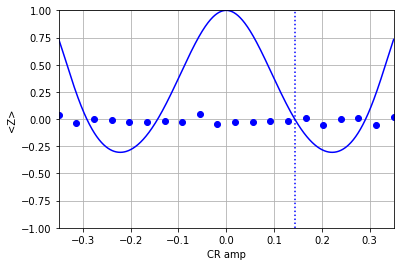

In [22]:
# control 1, target 3

exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(result_1_1, mem_ind=target, exp_name='cr_rabi_circ_%d' % cind)

valid_inds = np.where(np.abs(cr_amps) < 0.35)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()

In [23]:
# control 1, target 3

print(cr_pi2_amp)

0.14326554076552248


#### Phase calibration

In [24]:
# control 1, target 3

cr_phases = np.linspace(-np.pi, np.pi, 20)

# setup phase sweep experiment with Y measurement under control state = |0>
cr_phase_circ0 = qiskit.QuantumCircuit(qregs)
cr_phase_circ0 += cr_cal_circ
cr_phase_circ0.barrier(qregs[control], qregs[target])
cr_phase_circ0.sdg(qregs[target])
cr_phase_circ0.h(qregs[target])
cr_phase_circ0.measure_active()

# setup phase sweep experiment with Y measurement under control state = |1>
cr_phase_circ1 = qiskit.QuantumCircuit(qregs)
cr_phase_circ1.x(qregs[control])
cr_phase_circ1 += cr_cal_circ
cr_phase_circ1.barrier(qregs[control], qregs[target])
cr_phase_circ1.sdg(qregs[target])
cr_phase_circ1.h(qregs[target])
cr_phase_circ1.measure_active()

cr_phase_circs = []
for cind, cr_phase in enumerate(cr_phases):
    # control state = 0
    fixed_cr_circ0 = cr_phase_circ0.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ0.name = 'phase_swp_%d_0' % cind
    cr_phase_circs.append(fixed_cr_circ0)
    # control state = 1
    fixed_cr_circ1 = cr_phase_circ1.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ1.name = 'phase_swp_%d_1' % cind
    cr_phase_circs.append(fixed_cr_circ1)

transpiled_circuits = transpile(cr_phase_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_2 = assemble(scheds, backend, meas_level=2, shots=shots)

#result_1_2 = runner.run(qobj_1_2, '1-2_phi_cal')

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [25]:
#jobid_1_2_a = "606197116bc6ac4ad6a906fe"
#job_1_2_a = backend.retrieve_job(jobid_1_2_a)
#job_1_2_a.status()
#result_1_2 = job_1_2_a.result()

jobid_1_2_b = "605e5b6f405f5cdd5989a17f"
job_1_2_b = backend.retrieve_job(jobid_1_2_b)
job_1_2_b.status()
result_1_2 = job_1_2_b.result()

path = data_dir + "result_1_2b_c1_t3.json"

with open(path, 'w') as fp:
    json.dump(result_1_2.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    results_c3t1_dict = json.load(fp)
    result_1_2 = Result.from_dict(results_c3t1_dict) 

In [26]:
def cos_fit_00(x, a, b):
    return a * np.cos(x - b + np.pi)

def cos_fit_10(x, a, b):
    return a * np.cos(x - b)

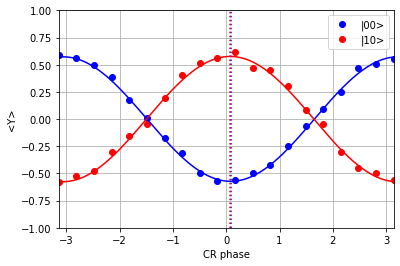

In [27]:
# control 1, target 3

exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_0' % cind)
    exp_y1[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_1' % cind)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2

x_interp = np.linspace(cr_phases[0], cr_phases[-1], 1000)
plt.plot(cr_phases, exp_y0, 'o', color='b', label='|00>')
plt.plot(cr_phases, exp_y1, 'o', color='r', label='|10>')
plt.plot(x_interp, cos_fit_00(x_interp, *params0), 'b')
plt.plot(x_interp, cos_fit_10(x_interp, *params1), 'r')
plt.plot([params0[1], params0[1]], [-1, 1], 'b:')
plt.plot([params1[1], params1[1]], [-1, 1], 'r:')
plt.xlim(cr_phases[0], cr_phases[-1])
plt.ylim(-1, 1)
plt.xlabel('CR phase')
plt.ylabel('<Y>')
plt.grid()
plt.legend()

In [28]:
# control 1, target 3

print(phi_opt)

# fix CR phase
cr_params['phi'] = phi_opt

0.07814449823460476


### Amplitude sweep process tomography

In [29]:
# control 1, target 3

shots = 2048

# cross resonance amplitudes to measure process tomography
cr_amplitudes = np.linspace(0, max_cr_amplitude, 6)

# create new QuantumCircuit layer abstraction of CR1 pulse schedule.
# this technique is necessary to work with current Ignis QPT module.
cr1_circ, ext_inst_map_cr1, ext_basis_gates_cr1 = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=False)

cr1_circ.draw(fold=-1, idle_wires=False)

┌────────────┐
q0_1: ┤0           ├
      │  zx_p(amp) │
q0_3: ┤1           ├
      └────────────┘

In [30]:
# setup CR amplitude sweep for QPT
qpt_cr1_circs = []
for cr_amp in cr_amplitudes:
    fixed_cr_circ = cr1_circ.bind_parameters({var_amp: cr_amp})
    qpt_cr1_circs.append(fixed_cr_circ)

# create QPT experiments
qobj_2_1, qcs, meas_labels = create_qpt_experiment(
    target_circuits=qpt_cr1_circs,
    control=control,
    target=target,
    backend=backend,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots)

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [31]:
#jobid_2_1_a = '605e5c53098cdff1051124e6'
#job_2_1_a = backend.retrieve_job(jobid_2_1_a)
#job_2_1_a.status()
#result_2_1_a = job_2_1_a.result()

#result_2_1 = result_2_1_a
#cr1_chois = [choi for choi in extract_choi_matrix(result_2_1, qcs, meas_labels)]
#np.save('%s/2-1_a_cr1_qpts_choi_mat.npy' % data_dir, [cr1_choi.data for cr1_choi in cr1_chois])

In [32]:
#jobid_2_1_b = "605081daac489097eb2a52ea"
#job_2_1_b = backend.retrieve_job(jobid_2_1_b)
#job_2_1_b.status()
#result_2_1_b = job_2_1_b.result()

#result_2_1 = result_2_1_b
#cr1_chois = [choi for choi in extract_choi_matrix(result_2_1, qcs, meas_labels)]
#np.save('%s/2-1_b_cr1_qpts_choi_mat.npy' % data_dir, [cr1_choi.data for cr1_choi in cr1_chois])

## CR calibration for control 3, target 1 

In [33]:
# control qubit index
q1 = 3
control = q1

# target qubit index
q2 = 1
target = q2

# use cache data
use_cache = False

import os, json
data_dir = os.getcwd() + '\\CR_data_c3_t1\\'
#os.makedirs(data_dir)

#### Calibration of CR phase

In [ ]:
# control 3, target 1

max_cr_amplitude = 0.35 # maximum cross resonance amplitude in E1
alignment = 16 # sample number restriction

# initial cross resonance pulse parameters E1
cr_params = {'duration': 60 * alignment, 'amp': var_amp, 'phi': var_phi, 'sigma': 2 * alignment, 'risefall': 4 * alignment}

config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()
cr_qubits = sorted([control, target])
qregs = qiskit.QuantumRegister(config.n_qubits)

u_index = config.control((control, target))[0].index 
print("control channel index:",u_index)

channels = [pulse.DriveChannel(control), pulse.DriveChannel(target), pulse.ControlChannel(u_index)] 
print(channels)

mem_ind = 0 if control > target else 1
print("index of memory slot at which the measurement data of target qubit is stored:",mem_ind)

# E_1_1 CR calibration circ
shots = 1024
cr_cal_circ, ext_inst_map, ext_basis_gates = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=True)

cr_cal_circ.draw(fold=-1, idle_wires=False)

In [35]:
# rough amp calibration
# control 3, target 1

cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 20)

# setup CR Rabi experiment with Z measurement
cr_rabi_circ = cr_cal_circ.copy()
cr_rabi_circ.measure_active()

cr_rabi_circs = []
for cind, cr_amp in enumerate(cr_amps):
    fixed_cr_circ = cr_rabi_circ.bind_parameters({var_amp: cr_amp, var_phi: 0})
    fixed_cr_circ.name = 'cr_rabi_circ_%d' % cind
    cr_rabi_circs.append(fixed_cr_circ)

transpiled_circuits = transpile(cr_rabi_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_1 = assemble(scheds, backend, meas_level=2, shots=shots)

#job_1_1_c3t1 = backend.run(qobj_1_1)
#job_1_1_c3t1.job_id()

In [36]:
jobid = '60673b3f237ef7470b84654c'
job = backend.retrieve_job(jobid)
#job_monitor(job)
#result_1_1_c3_t1_b = job.result()

In [ ]:
jobid = '60673b3f237ef7470b84654c'
job = backend.retrieve_job(jobid)
result_1_1_c3_t1_b = job.result()

path = data_dir + "result_1_1_b_c3_t1.json"

with open(path, 'w') as fp:
    json.dump(result_1_1_c3_t1.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    results_c3t1_dict = json.load(fp)
    result_1_1_c3_t1_b = Result.from_dict(results_c3t1_dict) 

In [ ]:
# control 3, target 1

result_1_1 = result_1_1_c3_t1_b

exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(result_1_1, mem_ind=target, exp_name='cr_rabi_circ_%d' % cind)

valid_inds = np.where(np.abs(cr_amps) < 0.35)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()

In [ ]:
# control 3, target 1

print(cr_pi2_amp)

In [ ]:
# control 3, target 1

# E_1_2: Phase calibration

cr_phases = np.linspace(-np.pi, np.pi, 20)

# setup phase sweep experiment with Y measurement under control state = |0>
cr_phase_circ0 = qiskit.QuantumCircuit(qregs)
cr_phase_circ0 += cr_cal_circ
cr_phase_circ0.barrier(qregs[control], qregs[target])
cr_phase_circ0.sdg(qregs[target])
cr_phase_circ0.h(qregs[target])
cr_phase_circ0.measure_active()

# setup phase sweep experiment with Y measurement under control state = |1>
cr_phase_circ1 = qiskit.QuantumCircuit(qregs)
cr_phase_circ1.x(qregs[control])
cr_phase_circ1 += cr_cal_circ
cr_phase_circ1.barrier(qregs[control], qregs[target])
cr_phase_circ1.sdg(qregs[target])
cr_phase_circ1.h(qregs[target])
cr_phase_circ1.measure_active()

cr_phase_circs = []
for cind, cr_phase in enumerate(cr_phases):
    # control state = 0
    fixed_cr_circ0 = cr_phase_circ0.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ0.name = 'phase_swp_%d_0' % cind
    cr_phase_circs.append(fixed_cr_circ0)
    # control state = 1
    fixed_cr_circ1 = cr_phase_circ1.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ1.name = 'phase_swp_%d_1' % cind
    cr_phase_circs.append(fixed_cr_circ1)

transpiled_circuits = transpile(cr_phase_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_2 = assemble(scheds, backend, meas_level=2, shots=shots)

In [ ]:
# control 3, target 1

jobid_1_2_a = "60630ad1eb9d76c4493a4058"
job_1_2_a = backend.retrieve_job(jobid_1_2_a)
result_1_2_a = job_1_2_a.result()

path = data_dir + "E_1_2_a_c3t1.json"
with open(path, 'w') as fp:
    json.dump(result_1_2.to_dict(), fp,default=str)  

with open(path, 'r') as fp:
    results_c3t1_dict = json.load(fp)
    result_1_2_a = Result.from_dict(results_c3t1_dict) 
      
#jobid_1_2_b = "605e5b6f405f5cdd5989a17f"
#job_1_2_b = backend.retrieve_job(jobid_1_2_b)
#result_1_2_b = job_1_2_b.result()

#path = data_dir + "E_1_2_b_c3t1.json"
#with open(path, 'w') as fp:
    #json.dump(result_1_2_b.to_dict(), fp,default=str)
    
#with open(path, 'r') as fp:
    #results_c3t1_dict = json.load(fp)
    #result_1_2_b = Result.from_dict(results_c3t1_dict) 

In [ ]:
# control 3, target 1

result_1_2 = result_1_2_a
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_0' % cind)
    exp_y1[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_1' % cind)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2

print(phi_opt)

In [ ]:
# control 3, target 1

result_1_2 = result_1_2_b
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_0' % cind)
    exp_y1[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_1' % cind)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2

print(phi_opt)

# 2. Cancellation tone calibration with Pauli Error Amplifying Technique

In [ ]:
# apply active cancellation tone for another CR drive along with CR tone for the qubit,
# which usually differs frequency delta/(2*pi)

In [ ]:
# TBC...

# 3. Simultaneous Sweep of both drive frequencies

with both qubits in exited state while sweeping

In [ ]:
# TBC...

# 4. Calibrate CCR gate by scanning over different durations

measure Cartan coefficients while sweeping CCR gate time

method: quantum process tomography (QPT)

In [ ]:
# TBC ...